In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from scipy.special import j0, jn_zeros
from numpy.fft import rfft, rfftfreq

In [2]:
propiedades = {
    0: "lower x edge [m]",
    1: "upper x edge [m]",
    2: "lower y edge [m]",
    3: "upper y edge [m]",
    4: "cell volume [m3]",
    5: "density [kg/m3]",
    6: "velocity x [m/s]",
    7: "velocity y [m/s]",
    8: "temperature [eV]",
    9: "SDE [W/m3]",
    10: "P_therm [Pa]",
    11: "P_rad [Pa]",
    12: "P_total [Pa]",
    13: "internal energy [J/kg]",
    14: "cv [J/kg/K]",
    15: "rho*cv [J/m3/K]",
    16: "sound speed [m/s]",
    17: "charge state",
    18: "electron density [e/m3]",
    19: "kinetic energy",
    20: "nmat",
    21: "fvol 0",
    22: "fvol 1",
    23: "fvol 2",
    24: "fvol 3",
    25: "fvol 4",
    26: "fvrho 0",
    27: "fvrho 1",
    28: "fvrho 2",
    29: "fvrho 3",
    30: "fvrhoe 0",
    31: "fvrhoe 1",
    32: "fvrhoe 2",
    33: "fvrhoe 3"
}


2D

In [3]:
def calcular_L_densidad(
    ruta_hdf5,
    eps=1e-12,
    dtype=np.float32
):
    """
    Calcula la longitud característica de densidad:
    L_rho = rho / |grad rho|
    usando memoria mapeada.
    """

    import numpy as np
    import os

    # -----------------------------
    # Carpeta
    # -----------------------------
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    # -----------------------------
    # MEMMAP
    # -----------------------------
    rho = np.load(os.path.join(carpeta, "prop_05.npy"), mmap_mode="r")
    Nt, Nz, Nr = rho.shape

    # -----------------------------
    # Archivo de salida
    # -----------------------------
    ruta_salida = os.path.join(carpeta, "prop_Lrho.npy")
    Lrho = np.lib.format.open_memmap(
        ruta_salida,
        mode="w+",
        dtype=dtype,
        shape=(Nt, Nz, Nr)
    )

    # -----------------------------
    # Loop temporal
    # -----------------------------
    for t in range(Nt):
        if t % 10 == 0:
            print(f"L_rho: {t}/{Nt}", end="\r")

        rho_t = rho[t]

        drho_dz, drho_dr = np.gradient(rho_t)
        grad_rho = np.sqrt(drho_dz**2 + drho_dr**2)

        L = rho_t / (grad_rho + eps)
        Lrho[t] = np.nan_to_num(L)

    print("\n✔ Longitud característica de densidad calculada")
    print("✔ Guardada en:", ruta_salida)

    return ruta_salida

def ver_Lrho_por_indice(ruta_hdf5, t_index):
    """
    Visualiza L_rho(z,r) en un instante temporal.
    """

    import os
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt

    nombre = os.path.splitext(os.path.basename(ruta_hdf5))[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_L = os.path.join(carpeta, "prop_Lrho.npy")
    if not os.path.exists(ruta_L):
        raise FileNotFoundError("No existe prop_Lrho.npy. Ejecuta calcular_L_densidad().")

    Lrho = np.load(ruta_L)
    Nt, Nz, Nr = Lrho.shape

    if t_index < 0 or t_index >= Nt:
        raise ValueError("t_index fuera de rango")

    # Leer tiempos
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for ds in f.values():
            if "time" in ds.attrs:
                tiempos.append(ds.attrs["time"][0])

    tiempos = np.array(tiempos)
    if len(tiempos) != Nt:
        tiempos = np.arange(Nt)

    t_ns = tiempos[t_index] * 1e9

    frame = Lrho[t_index]
    vmin, vmax = np.percentile(frame, [2, 98])

    plt.figure(figsize=(6,5))
    plt.imshow(frame, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
    plt.xlabel("R [µm]")
    plt.ylabel("Z [µm]")
    plt.title(rf"$L_\rho$ | t = {t_ns:.3f} ns")
    plt.colorbar(label=r"$L_\rho$ [m]")
    plt.tight_layout()
    plt.show()


In [4]:
def animar_Lrho_mp4(
    ruta_hdf5,
    fps=10,
    percentiles=(2, 98)
):
    """
    Genera un MP4 de la evolución temporal de L_rho.
    """

    import os
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, FFMpegWriter

    nombre = os.path.splitext(os.path.basename(ruta_hdf5))[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_L = os.path.join(carpeta, "prop_Lrho.npy")
    if not os.path.exists(ruta_L):
        raise FileNotFoundError("No existe prop_Lrho.npy")

    Lrho = np.load(ruta_L)
    Nt, Nz, Nr = Lrho.shape

    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for ds in f.values():
            if "time" in ds.attrs:
                tiempos.append(ds.attrs["time"][0])

    tiempos = np.array(tiempos)
    if len(tiempos) != Nt:
        tiempos = np.arange(Nt)

    tiempos_ns = tiempos * 1e9

    vmin, vmax = np.percentile(Lrho, percentiles)

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(Lrho[0], origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)

    ax.set_xlabel("R [µm]")
    ax.set_ylabel("Z [µm]")
    titulo = ax.set_title(f"t = {tiempos_ns[0]:.3f} ns")

    plt.colorbar(im, ax=ax, label=r"$L_\rho$ [m]")

    def update(i):
        im.set_data(Lrho[i])
        titulo.set_text(f"t = {tiempos_ns[i]:.3f} ns")
        return im, titulo

    anim = FuncAnimation(fig, update, frames=Nt, interval=1000/fps)
    salida = os.path.join(carpeta, "Lrho.mp4")
    anim.save(salida, writer=FFMpegWriter(fps=fps))
    plt.close(fig)

    print("✔ MP4 guardado en:", salida)


In [5]:
def ver_Lrho_por_tiempos(ruta_hdf5, tiempos_ns):
    """
    Visualiza la longitud característica de densidad L_rho(z,r)
    en varios instantes temporales dados en ns.
    Todos los tiempos se muestran en la misma figura.
    """

    import os
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt

    # -----------------------------
    # Carpeta y archivo L_rho
    # -----------------------------
    nombre = os.path.splitext(os.path.basename(ruta_hdf5))[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)
    ruta_L = os.path.join(carpeta, "prop_Lrho.npy")

    if not os.path.exists(ruta_L):
        raise FileNotFoundError(
            "No existe prop_Lrho.npy. Ejecuta calcular_L_densidad()."
        )

    # mmap para no sobrecargar memoria
    Lrho = np.load(ruta_L, mmap_mode="r")
    Nt, Nz, Nr = Lrho.shape

    # -----------------------------
    # Leer tiempos reales del HDF5
    # -----------------------------
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for ds in f.values():
            if "time" in ds.attrs:
                tiempos.append(float(ds.attrs["time"][0]))

    tiempos = np.array(tiempos)
    if len(tiempos) != Nt:
        tiempos = np.arange(Nt, dtype=float)

    tiempos_ns_reales = tiempos * 1e9

    # -----------------------------
    # Mapear tiempos_ns -> índices
    # -----------------------------
    indices = [
        np.argmin(np.abs(tiempos_ns_reales - t))
        for t in tiempos_ns
    ]

    # -----------------------------
    # Escala de color global
    # -----------------------------
    vmin, vmax = np.percentile(Lrho, [2, 98])

    # -----------------------------
    # Plot en subplots
    # -----------------------------
    n = len(indices)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5), squeeze=False)

    for ax, idx, t in zip(axes[0], indices, tiempos_ns):
        frame = Lrho[idx]

        im = ax.imshow(
            frame,
            origin="lower",
            cmap="viridis",
            vmin=vmin,
            vmax=vmax
        )

        ax.set_xlabel("R [µm]")
        ax.set_ylabel("Z [µm]")
        ax.set_title(rf"$t \approx {t:.3f}$ ns")

        plt.colorbar(
            im,
            ax=ax,
            fraction=0.046,
            pad=0.04,
            label=r"$L_\rho$ [m]"
        )

    fig.suptitle("Longitud característica de densidad $L_\\rho$", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


PROMEDIO 1D

In [ ]:
ruta = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HD.h5"]

for r in ruta:
    calcular_L_densidad(r)
    animar_Lrho_mp4(r, fps=10)

L_rho: 290/299
✔ Longitud característica de densidad calculada
✔ Guardada en: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LD\prop_Lrho.npy
✔ MP4 guardado en: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LD\Lrho.mp4
L_rho: 340/348
✔ Longitud característica de densidad calculada
✔ Guardada en: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LD\prop_Lrho.npy
✔ MP4 guardado en: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LD\Lrho.mp4


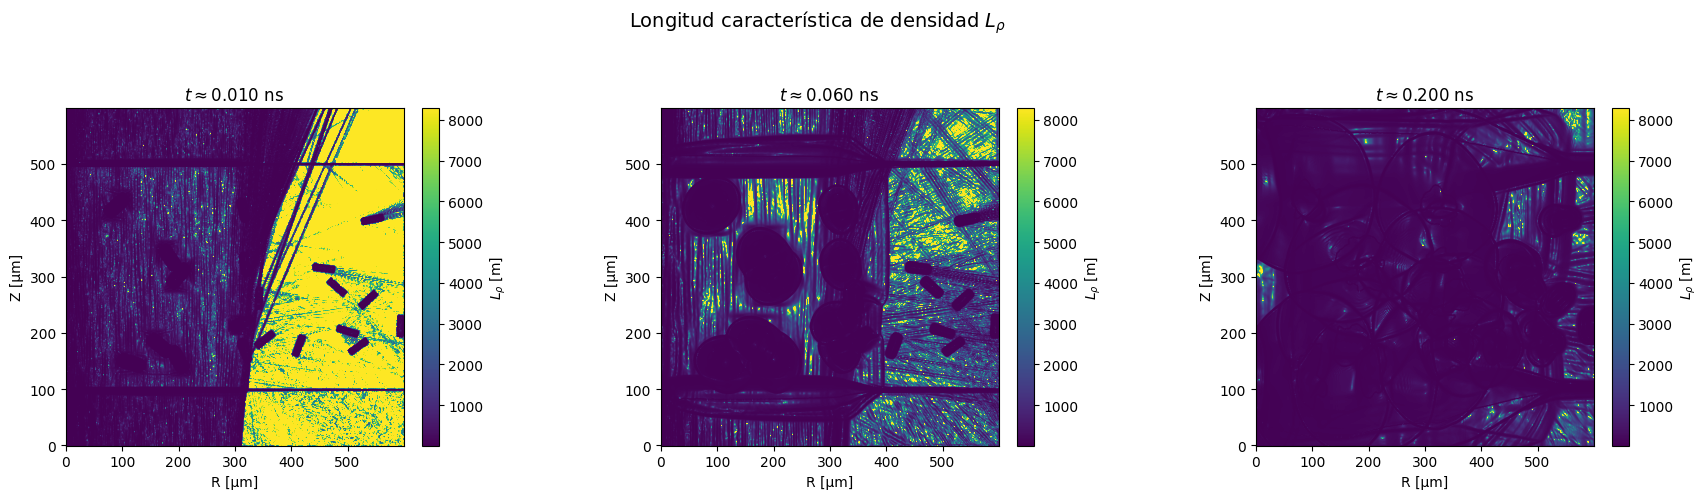

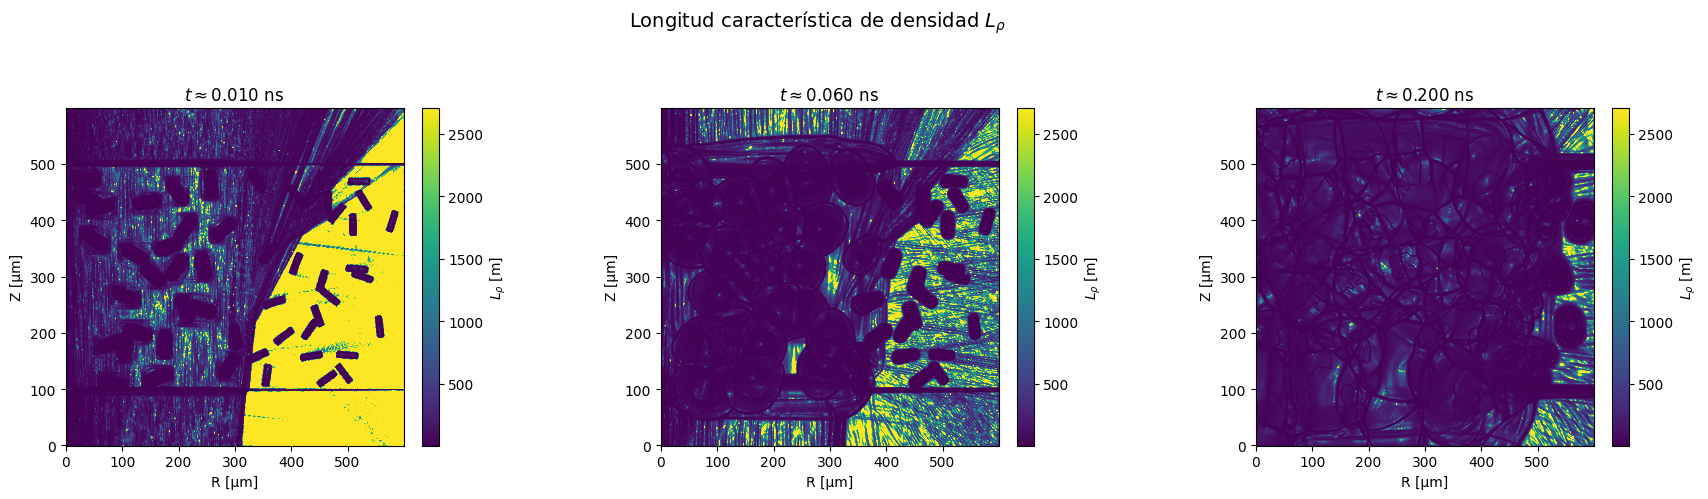

In [8]:
ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LD.h5",  r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LD.h5"]

t_ns = [ 0.01, 0.06, 0.2]
t_ns2 = [ 0.05, 0.2, 0.8]

for r in ruta_hdf5:
    #vr_RT_total_por_tiempos(
     #  r,
     #  tiempos_ns= t_ns2
    #

    ver_Lrho_por_tiempos(
        r,
        tiempos_ns = t_ns
    )


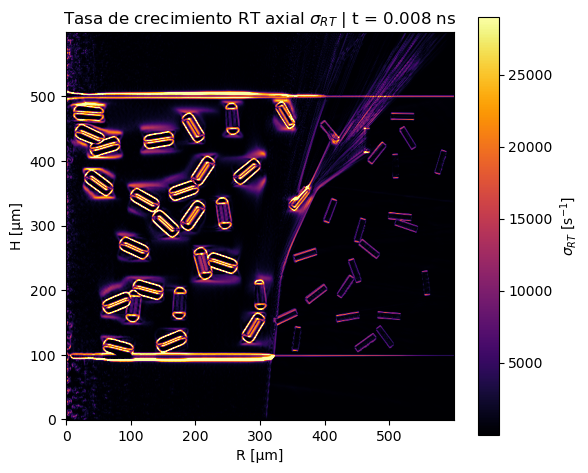

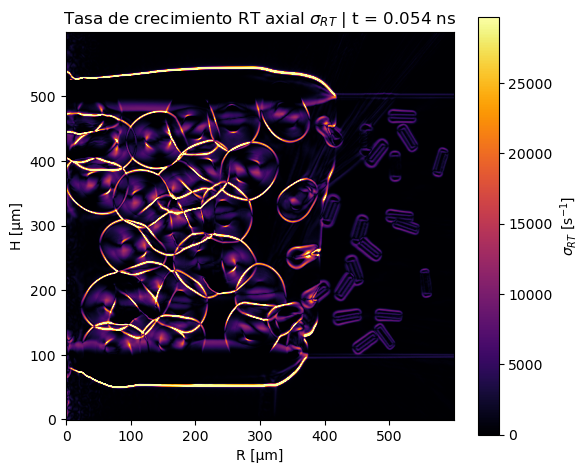

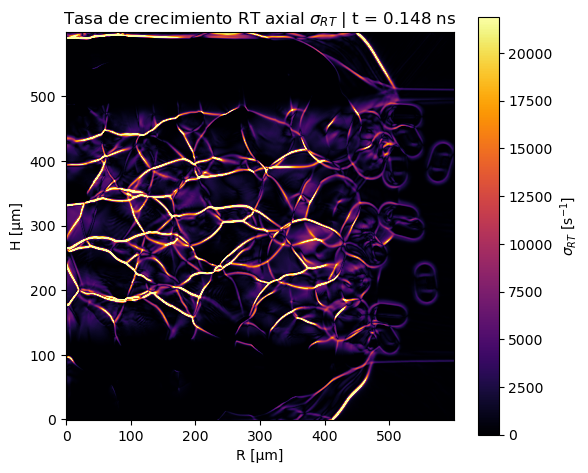

In [60]:
ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LD.h5"
t_index = [5, 33, 131]

for t in t_index:
    ver_RT_axial_por_indice(ruta_hdf5, t)
